<a href="https://colab.research.google.com/github/gcosma/RSS_Course_Code/blob/main/P2FairlearnEthicalAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial on Fairness in AI systems: <br>From social context to practice using Fairlearn

---
This is a modified and extended version of the _SciPy 2021 Tutorial: Fairness in AI systems: From social context to practice using Fairlearn by Manojit Nandi, Miroslav Dudík, Triveni Gandhi, Lisa Ibañez, Adrin Jalali, Michael Madaio, Hanna Wallach, Hilde Weerts is licensed under
[CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)._

Fairness in AI systems is an interdisciplinary field of research and practice that aims to understand and address some of the negative impacts of AI systems on society. 

In this tutorial, we will walk through the process of assessing and mitigating fairness-related harms in the context of a health care system. 

Participants will use the open-source Fairlearn library to assess ML models for performance disparities across different racial groups and mitigate those disparities using a variety of algorithmic techniques.

# **Part 1: Prepare environment**

## Install packages

* **machine learning and data processing**: _scikit-learn_, _pandas_, _numpy_
* **plotting**: _seaborn_, _matplotlib_
* **AI fairness**: _Fairlearn_ 

In [ ]:
!pip install --upgrade fairlearn==0.7.0
!pip install --upgrade scikit-learn
!pip install --upgrade seaborn

## Import and set up packages

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.float_format", "{:.3f}".format)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 

In [ ]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.utils import Bunch
from sklearn.metrics import (
    balanced_accuracy_score,
    roc_auc_score,
    accuracy_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    plot_roc_curve)
from sklearn import set_config

set_config(display="diagram")

In [ ]:
#From the Fairlearn library import metrics
from fairlearn.metrics import (
    MetricFrame,
    true_positive_rate,
    false_positive_rate,
    false_negative_rate,
    selection_rate,
    count,
    false_negative_rate_difference
)

from fairlearn.postprocessing import ThresholdOptimizer, plot_threshold_optimizer
from fairlearn.postprocessing._interpolated_thresholder import InterpolatedThresholder
from fairlearn.postprocessing._threshold_operation import ThresholdOperation
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds, TruePositiveRateParity

In [ ]:
from IPython import display
from datetime import date

## Load the dataset


We next load the dataset and review the meaning of its columns.


In [ ]:
#Load the dataset
df = pd.read_csv("https://raw.githubusercontent.com/fairlearn/talks/main/2021_scipy_tutorial/data/diabetic_preprocessed.csv")

In [ ]:
df.head(50)

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,1,Other,41,0,1,...,No,No,False,False,False,False,False,NO,0,0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3,Missing,59,0,18,...,Ch,Yes,False,False,False,False,False,>30,1,0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2,Missing,11,5,13,...,No,Yes,False,False,False,True,True,NO,0,0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2,Missing,44,1,16,...,Ch,Yes,False,False,False,False,False,NO,0,0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,Missing,51,0,8,...,Ch,Yes,False,False,False,False,False,NO,0,0
5,Caucasian,Male,30-60 years,Discharged to Home,Referral,3,Missing,31,6,16,...,No,Yes,False,False,False,False,False,>30,1,0
6,Caucasian,Male,Over 60 years,Discharged to Home,Referral,4,Missing,70,1,21,...,Ch,Yes,False,False,False,False,False,NO,0,0
7,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,5,Missing,73,0,12,...,No,Yes,False,False,False,False,False,>30,1,0
8,Caucasian,Female,Over 60 years,Discharged to Home,Other,13,Missing,68,2,28,...,Ch,Yes,False,False,False,False,False,NO,0,0
9,Caucasian,Female,Over 60 years,Other,Other,12,InternalMedicine,33,3,18,...,Ch,Yes,False,False,False,False,False,NO,0,0


In [ ]:
# Show the values of all binary and categorical features
categorical_values = {}
for col in df:
  if col not in {'time_in_hospital', 'num_lab_procedures',
                 'num_procedures', 'num_medications', 'number_diagnoses'}:
    categorical_values[col] = pd.Series(df[col].value_counts().index.values)
categorical_values_df = pd.DataFrame(categorical_values).fillna('')
categorical_values_df.T

,0,1,2,3,4,5
race,Caucasian,AfricanAmerican,Unknown,Hispanic,Other,Asian
gender,Female,Male,Unknown/Invalid,,,
age,Over 60 years,30-60 years,30 years or younger,,,
discharge_disposition_id,Discharged to Home,Other,,,,
admission_source_id,Emergency,Referral,Other,,,
medical_specialty,Missing,Other,InternalMedicine,Emergency/Trauma,Family/GeneralPractice,Cardiology
primary_diagnosis,Other,Respiratory Issues,Diabetes,Genitourinary Issues,Musculoskeletal Issues,
max_glu_serum,None,Norm,>200,>300,,
A1Cresult,None,>8,Norm,>7,,
insulin,No,Steady,Down,Up,,


We mark all categorical features: 

In [ ]:
categorical_features = [
    "race",
    "gender",
    "age",
    "discharge_disposition_id",
    "admission_source_id",
    "medical_specialty",
    "primary_diagnosis",
    "max_glu_serum",
    "A1Cresult",
    "insulin",
    "change",
    "diabetesMed",
    "readmitted"
]

In [ ]:
for col_name in categorical_features:
  df[col_name] = df[col_name].astype("category")

## Group sample sizes 

In [ ]:
#drop the gender group Unknown/Invalid
df = df.query("gender != 'Unknown/Invalid'")
df["gender"].value_counts(normalize=True).mul(100)


Female            53.760
Male              46.240
Unknown/Invalid    0.000
Name: gender, dtype: float64

In [ ]:
# retain the original race as race_all, and merge Asian+Hispanic+Other 
df["race_all"] = df["race"]
df["race"] = df["race"].replace({"Asian": "Other", "Hispanic": "Other"})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Part 2: Training the initial model

We next train a classification model to predict our target variable (readmission within 30 days) while optimizing balanced accuracy.

What kind of model should we train? Deep neural nets? Random forests? Logistic regression?

There are a variety of considerations. We highlight two:

* **Interpretability.** Interpretability is tightly linked with questions of fairness. There are several reasons why it is important to have interpretable models that are open to the stakeholder scrutiny:
  * It allows discovery of fairness issues that were not discovered by the data science team.
  * It provides a path toward recourse for those that are affected by the model.
  * It allows for a *face validity* check, a "sniff test", by experts to verify that the model "makes sense" (at the face value). While this step is subjective, it is really important when the model is applied to different populations than those on which the assessment was conducted.

* **Model expressiveness.** How well can the model separate positive examples from negative examples? How well can it do so given the available dataset size? Can it do so across all groups or does it need to trade off performance on one group against performance on another group?

Some additional considerations are training time (this impacts the ability to iterate), familiarity (this impacts the ability to fine tune and debug), and carbon footprint (this impacts the Earth climate both directly and indirectly by normalizing unnecessarily heavy workloads).

### Decision point: Model type

We will use a logistic regression model. Our reasoning:

* **Interpretability**. Logistic models over a small number of variables (as used here) are highly interpretable in the sense that stakeholders can simulate them easily.

* **Model expressiveness**. Logistic regression predictions are described by a linear weighting of the feature values. The concern might be that this is too simple. The previous work by [Strack et al. (2014)](https://www.hindawi.com/journals/bmri/2014/781670/), which also used a logistic model to predict readmission rates concluded that a slightly more expressive model might be useful (their analysis uncovered 8 pairwise interactions that were significant, see their Table 5).

## Prepare training and test datasets

As we mentioned in the task definition, our target variable is **readmission within 30 days**, and our sensitive feature for the purposes of fairness assessment is **race**.


In [ ]:
target_variable = "readmit_30_days"
demographic = ["race", "gender"]
sensitive = ["race"]
# If multiple sensitive features are chosen, the rest of the script considers intersectional groups.

In [ ]:
Y, A = df.loc[:, target_variable], df.loc[:, sensitive]

We next drop the features that we don't want to use in our model and expand the categorical features into 0/1 indicators ("dummies").

In [ ]:
X = pd.get_dummies(df.drop(columns=[
    "race",
    "race_all",
    "discharge_disposition_id",
    "readmitted",
    "readmit_binary",
    "readmit_30_days"
]))

In [ ]:
X.head() # sanity check

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,...,A1Cresult_None,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up,change_Ch,change_No,diabetesMed_No,diabetesMed_Yes
0,1,41,0,1,1,False,False,False,False,False,...,1,0,0,1,0,0,0,1,1,0
1,3,59,0,18,9,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
2,2,11,5,13,6,False,False,False,True,True,...,1,0,0,1,0,0,0,1,0,1
3,2,44,1,16,7,False,False,False,False,False,...,1,0,0,0,0,1,1,0,0,1
4,1,51,0,8,5,False,False,False,False,False,...,1,0,0,0,1,0,1,0,0,1


We split our data into a training and test portion. The test portion will be used to evaluate our performance metric (i.e., balanced accuracy), but also for fairness assessment. The split is half/half for training and test to ensure that we have sufficient sample sizes for fairness assessment.

In [ ]:
random_seed = 445
np.random.seed(random_seed)

In [ ]:
X_train, X_test, Y_train, Y_test, A_train, A_test, df_train, df_test = train_test_split(
    X,
    Y,
    A,
    df,
    test_size=0.50,
    stratify=Y,
    random_state=random_seed
)

Our performance metric is **balanced accuracy**, so for the purposes of training (but not evaluation!) we will resample the data set, so that it has the same number of positive and negative examples. This means that we can use estimators that optimize standard accuracy (although some estimators allow the use us importance weights).


Because we are downsampling the number of negative examples, we create a training dataset with a significantly lower number of data points. For more complex machine learning models, this lower number of training data points may affect the model's accuracy.

In [ ]:
def resample_dataset(X_train, Y_train, A_train):

  negative_ids = Y_train[Y_train == 0].index
  positive_ids = Y_train[Y_train == 1].index
  balanced_ids = positive_ids.union(np.random.choice(a=negative_ids, size=len(positive_ids)))

  X_train = X_train.loc[balanced_ids, :]
  Y_train = Y_train.loc[balanced_ids]
  A_train = A_train.loc[balanced_ids, :]
  return X_train, Y_train, A_train

In [ ]:
X_train_bal, Y_train_bal, A_train_bal = resample_dataset(X_train, Y_train, A_train)

## Save descriptive statistics of training and test data

We next evaluate and save descriptive statistics of the training dataset.

Text(0.5, 1.0, 'Sensitive Attributes for Training Dataset')

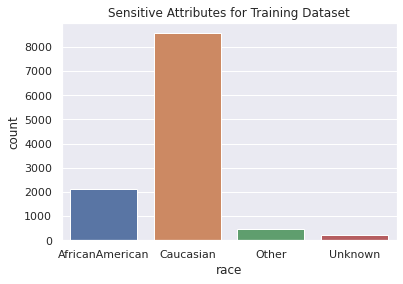

In [ ]:
sns.countplot(x="race", data=A_train_bal)
plt.title("Sensitive Attributes for Training Dataset")

Text(0.5, 1.0, 'Target Label Histogram for Training Dataset')

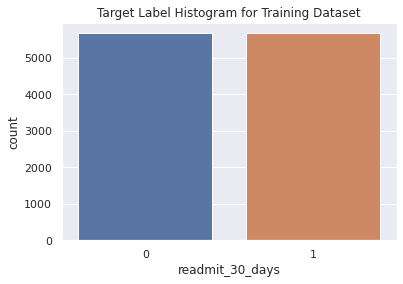

In [ ]:
sns.countplot(x=Y_train_bal)
plt.title("Target Label Histogram for Training Dataset")

Text(0.5, 1.0, 'Sensitive Attributes for Testing Dataset')

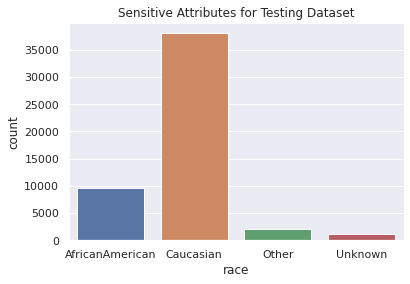

In [ ]:
sns.countplot(x="race", data=A_test)
plt.title("Sensitive Attributes for Testing Dataset")

Text(0.5, 1.0, 'Target Label Histogram for Test Dataset')

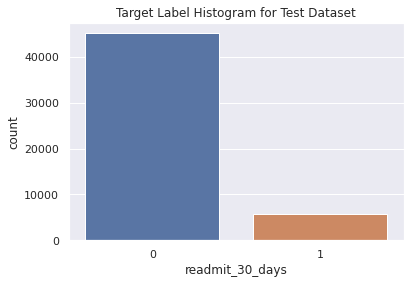

In [ ]:
sns.countplot(x=Y_test)
plt.title("Target Label Histogram for Test Dataset")

## Train the model

We train a logistic regression model and save its predictions on test data for analysis.

In [ ]:
unmitigated_pipeline = Pipeline(steps=[
    ("preprocessing", StandardScaler()),
    ("logistic_regression", LogisticRegression(max_iter=1000))
])

In [ ]:
unmitigated_pipeline.fit(X_train_bal, Y_train_bal)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('logistic_regression', LogisticRegression(max_iter=1000))])

In [ ]:
Y_pred_proba = unmitigated_pipeline.predict_proba(X_test)[:,1]
Y_pred = unmitigated_pipeline.predict(X_test)

Check model performance on test data.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


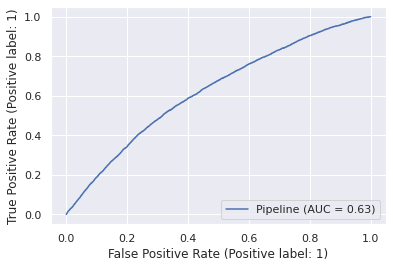

In [ ]:
# Plot ROC curve of probabilistic predictions
plot_roc_curve(unmitigated_pipeline, X_test, Y_test);

In [ ]:
# Show balanced accuracy rate of the 0/1 predictions
balanced_accuracy_score(Y_test, Y_pred)

0.5937900251950625

As we see, the performance of the model is well above the performance of a coin flip (whose performance would be 0.5 in both cases), albeit it is quite far from a perfect classifier (whose performance would be 1.0 in both cases).


## Inspect the coefficients of trained model

We check the coefficients of the fitted model to make sure that they "makes sense". While subjective, this step is important and helps catch mistakes and might point out to some fairness issues. However, we will systematically assess the fairness of the model in the next section.

*Note that coefficients are also a proxy for "feature importance", but this interpretation can be misleading when features are highly correlated.*

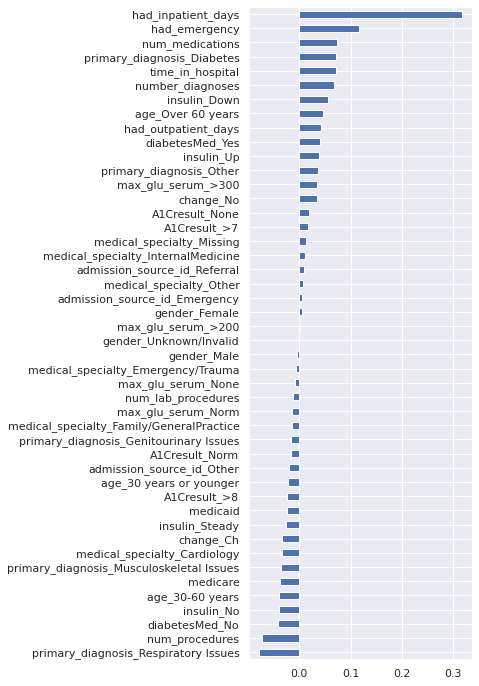

In [ ]:
coef_series = pd.Series(data=unmitigated_pipeline.named_steps["logistic_regression"].coef_[0], index=X.columns)
coef_series.sort_values().plot.barh(figsize=(4, 12), legend=False);

# **Fairness assessment**

## Measuring fairness-related harms





The goal of fairness assessment is to answer the question: *Which groups of people may be disproportionately negatively impacted by an AI system and in what ways?*

The steps of the assesment are as follows:
1. Identify harms
2. Identify the groups that might be harmed
3. Quantify harms
4. Compare quantified harms across the groups

We next examine these four steps in more detail.

### 1. Identify harms

For example, in a system for screening job applications, qualified candidates that are automatically rejected experience an allocation harm. In a speech-to-text transcription system, high error rates constitute harm in the quality of service.

**In the health care scenario**, the patients that would benefit from a care management program, but are not recommended for it experience an allocation harm. In the context of the classification scenario these are **FALSE NEGATIVES**.

### 2. Identify the groups that might be harmed

In most applications, we consider demographic groups including historically marginalized groups (e.g., based on gender, race, ethnicity). We should also consider groups that are relevant to a particular application. For example, for speech-to-text transcription, groups based on the regional dialect or being a native or a non-native speaker.

It is also important to consider group intersections, for example, in addition to considering groups according to gender and groups according to race, it is also important to consider their intersections (e.g., Black women, Latinx nonbinary people, etc.).

**In the health care scenario**, based on the previous work, we focus on groups defined by **RACE**.

### 3. Quantify harms

Define metrics that quantify harms or benefits:

* In a job screening scenario, we need to quantify the number of candidates that are classified as "negative" (not recommended for the job), but whose true label is "positive" (they are qualified). One possible metric is the **false negative rate**: fraction of qualified candidates that are screened out.

* In a speech-to-text scenario, the harm could be measured by **word error rate**, number of mistakes in a transcript divided by the overall number of words.

* **In the health care scenario**, we could consider two metrics for quantifying harms / benefits:
  * **false negative rate**: fraction of patients that are readmitted within 30 days, but that are not recommended for the care management program; this quantifies harm
  * **selection rate**: overall fraction of patients that are recommended for the care management program (regardless of whether they are readmittted with 30 days or no); this quantifies benefit; here the assumption is that all patients benefit similarly from the extra care.

There are several reasons for including selection rate in addition to false negative rate. We would like to monitor how the benefits are allocated, focusing on groups that might be disadvantaged. Another reason is to get extra robustness in our assessement, because our measure (i.e., readmission within 30 days) is only an imperfect measure of our construct (who is most likely to benefit from the care management program). The auxiliary metrics, like selection rate, may alert us to large disparities in how the benefit is allocated, and allow us to catch issues that we might have missed.


### 4. Compare quantified harms across the groups

The workhorse of fairness assessment are _disaggregated metrics_, which are **metrics evaluated on slices of data**. For example, to measure harms due to errors, we would begin by evaluating the errors on each slice of the data that corresponds to a group we identified in Step 2.
If some of the groups are seeing much larger errors than other groups, we would flag this as a fairness harm.

To summarize the disparities in errors (or other metrics), we may want to report quantities such as the **difference** or **ratio** of the metric values between the best and the worst slice. In settings where the goal is to guarantee certain minimum quality of service (such as speech recognition), it is also meaningful to report the **worst performance** across all considered groups.



For example, when comparing false negative rate across groups defined by race, we may summarize our findings with a table like the following:

| | false negative rate<br>(FNR) |
|---|---|
| AfricanAmerican | 0.43 |
| Caucasian | 0.44 |
| Other | 0.52 |
| Unknown | 0.67 |
| | |
|_largest difference_| 0.24 &nbsp;&nbsp;(best is 0.0)|
|_smallest ratio_| 0.64 &nbsp;&nbsp;(best is 1.0)|
|_maximum_<br>_(worst-case) FNR_|0.67|

## Fairness assessment with `MetricFrame`

Fairlearn provides the data structure called `MetricFrame` to enable evaluation of disaggregated metrics. We will show how to use a `MetricFrame` object to assess the trained `LogisticRegression` classifier for potential fairness-related harms.



In [ ]:
# In its simplest form MetricFrame takes four arguments:
#    metric_function with signature metric_function(y_true, y_pred)
#    y_true: array of labels
#    y_pred: array of predictions
#    sensitive_features: array of sensitive feature values

mf1 = MetricFrame(metrics=false_negative_rate,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are stored in a pandas Series mf1.by_group:
mf1.by_group

race
AfricanAmerican   0.428
Caucasian         0.442
Other             0.523
Unknown           0.670
Name: false_negative_rate, dtype: object

In [ ]:
# The largest difference, smallest ratio and worst-case performance are accessed as
#   mf1.difference(), mf1.ratio(), mf1.group_max()

print(f"difference: {mf1.difference():.3}\n"
      f"ratio: {mf1.ratio():.3}\n"
      f"max across groups: {mf1.group_max():.3}")

difference: 0.242
ratio: 0.639
max across groups: 0.67


In [ ]:
# You can also evaluate multiple metrics by providing a dictionary

metrics_dict = {
    "selection_rate": selection_rate,
    "false_negative_rate": false_negative_rate,
    "balanced_accuracy": balanced_accuracy_score,
}

metricframe_unmitigated = MetricFrame(metrics=metrics_dict,
                  y_true=Y_test,
                  y_pred=Y_pred,
                  sensitive_features=df_test['race'])

# The disaggregated metrics are then stored in a pandas DataFrame:

metricframe_unmitigated.by_group

,selection_rate,false_negative_rate,balanced_accuracy
race,,,
AfricanAmerican,0.400,0.428,0.597
Caucasian,0.391,0.442,0.594
Other,0.328,0.523,0.584
Unknown,0.264,0.670,0.536


In [ ]:
# The largest difference, smallest ratio, and the maximum and minimum values
# across the groups are then all pandas Series, for example:

metricframe_unmitigated.difference()

selection_rate        0.137
false_negative_rate   0.242
balanced_accuracy     0.061
dtype: object

In [ ]:
# You'll probably want to view them transposed:

pd.DataFrame({'difference': metricframe_unmitigated.difference(),
              'ratio': metricframe_unmitigated.ratio(),
              'group_min': metricframe_unmitigated.group_min(),
              'group_max': metricframe_unmitigated.group_max()}).T

,selection_rate,false_negative_rate,balanced_accuracy
difference,0.137,0.242,0.061
ratio,0.659,0.639,0.897
group_min,0.264,0.428,0.536
group_max,0.400,0.670,0.597


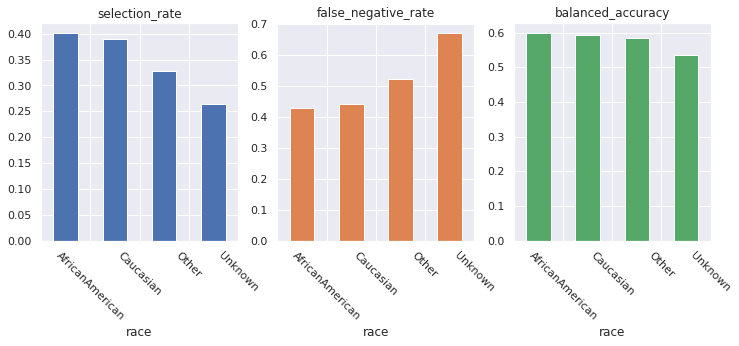

In [ ]:
# You can also easily plot all of the metrics using DataFrame plotting capabilities

metricframe_unmitigated.by_group.plot.bar(subplots=True, layout= [1,3], figsize=(12, 4),
                      legend=False, rot=-45, position=1.5);

According to the above bar chart, it seems that the group *Unknown* is selected for the care management program less often than other groups as reflected by the selection rate. Also this group experiences the largest false negative rate, so a larger fraction of group members that are likely to benefit from the care management program are not selected. Finally, the balanced accuracy on this group is also the lowest.



We observe disparity, even though we did not include race in our model. There's a variety of reasons why such disparities may occur. It could be due to representational issues (i.e., not enough instances per group), or because the feature distribution itself differs across groups (i.e., different relationship between features and target variable, obvious example would be people with darker skin in facial recognition systems, but can be much more subtle). Real-world applications often exhibit both kinds of issues at the same time.

<a name="train-other-models"></a>
## Exercise: Train other fairness-unaware models

In this section, you'll be training your own fairness-unaware model and evaluate the model using the `MetricFrame` for fairness-related harms.

We encourage you to explore the model's performance across different sensitive features (such as `age` or `gender`) as well as different model performance metrics.

1.) First, let's train our machine learning model. We'll create a `HistGradientBoostingClassifier` and fit it to the balanced training data set.

In [ ]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Create your model here
clf = HistGradientBoostingClassifier()

# Fit the model to the training data
clf.fit(X_train_bal, Y_train_bal)
exercise_pred = clf.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:17: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  "Since version 1.0, "


2.) Next, let's evaluate the fairness of the model using the `MetricFrame`. In the below cells, create a `MetricFrame` that looks at the following metrics:


*   _Count_: The number of data points belonging to each sensitive feature category.
*   _False Positive Rate_: $\dfrac{FN}{FN+TP}$
*  _Recall Score_: $\dfrac{TP}{TP+FN}$

As an extra challenge, you can use the prediction probabilities to compute the _ROC AUC Score_ for each sensitive group pair.



In [ ]:
# Define exercise fairness metrics of interest here

exercise_metrics = {
    "count": count,
    "false_positive_rate": false_positive_rate,
    "recall_score": recall_score
}


Now, let's create our `MetricFrame` using the metrics listed above with the sensitive groups of `race` and `gender`.

In [ ]:
metricframe_exercise = MetricFrame(
    metrics=false_positive_rate,
    y_true=Y_test,
    y_pred=Y_pred,
    sensitive_features=df_test['age']
)


3.) Finally, play around with the plotting capabilities of the `MetricFrame` in the below section.



In [ ]:
metricframe_exercise.difference()

0.14961537364663374

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb06e195b90>,
      dtype=object)

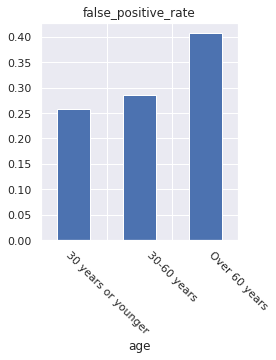

In [ ]:
# Plot some of the performance disparities here
metricframe_exercise.by_group.plot.bar(subplots=True, layout=[1,3], figsize=(12, 4),
                                       legend=False, rot=-45, position=1.5)


The charts above are based on test data, so without any uncertainty quantification (such as error bars or confidence intervals), we cannot reliably compare these data statistics. Next optional section shows how to augment MetricFrame with the report of error bars.

## Adding error bars [OPTIONAL SECTION]

In this section, we define new custom metrics that quantify errors in our estimates of selection rate, false negative rate and balanced accuracy, and then review our metrics again.

In [ ]:
# All of our error bar calculations are based on normal approximation to
# the binomial variables.

def error_bar_normal(n_successes, n_trials, z=1.96):
  """
  Computes the error bars for the parameter p of a binomial variable
  using normal approximation. The default value z corresponds to the 95%
  confidence interval.
  """
  point_est = n_successes / n_trials
  error_bar = z*np.sqrt(point_est*(1-point_est))/np.sqrt(n_trials)
  return error_bar

def fpr_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the false positive rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(fp, tn+fp)

def fnr_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the false negative rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(fn, fn+tp)

def selection_rate_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the selection rate
  """
  tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred).ravel()
  return error_bar_normal(tp+fp, tn+fp+fn+tp)

def balanced_accuracy_error(Y_true, Y_pred):
  """
  Compute the 95%-error bar for the balanced accuracy
  """
  fnr_err, fpr_err = fnr_error(Y_true, Y_pred), fpr_error(Y_true, Y_pred)
  return np.sqrt(fnr_err**2 + fpr_err**2)/2

We next create a metric frame that includes the sample sizes and error bar sizes in addition to the metrics that we have used previously.

In [ ]:
metrics_with_err_bars = {
    "count": count,
    "selection_rate": selection_rate,
    "selection_err_bar": selection_rate_error,
    "false_negative_rate": false_negative_rate,
    "fnr_err_bar": fnr_error,
    "balanced_accuracy": balanced_accuracy_score,
    "bal_acc_err_bar": balanced_accuracy_error
}

# sometimes we will only want to display metrics without error bars
metrics_to_display = [
    "count",
    "selection_rate",
    "false_negative_rate",
    "balanced_accuracy"
]

# sometimes we will only want to show the difference values of the metrics other than count
differences_to_display = [
    "selection_rate",
    "false_negative_rate",
    "balanced_accuracy"
]

In [ ]:
metricframe_unmitigated_w_err = MetricFrame(
    metrics=metrics_with_err_bars,
    y_true=Y_test,
    y_pred=Y_pred,
    sensitive_features=A_test
)

In [ ]:
unmitigated_groups = metricframe_unmitigated_w_err.by_group
unmitigated_groups # show both the metrics as well as the error bars

,count,selection_rate,selection_err_bar,false_negative_rate,fnr_err_bar,balanced_accuracy,bal_acc_err_bar
race,,,,,,,
AfricanAmerican,9616,0.400,0.010,0.428,0.029,0.597,0.015
Caucasian,38039,0.391,0.005,0.442,0.015,0.594,0.008
Other,2113,0.328,0.020,0.523,0.066,0.584,0.034
Unknown,1114,0.264,0.026,0.670,0.095,0.536,0.049


We see that for smaller sample sizes we have larger error bars. The problem is further exacerbated for false negative rate, which is estimated only over *positive examples* and so its sample sizes is further reduced due to label imbalance.

We next visualize the metrics with the corresponding error bars using a custom plotting function.

In [ ]:
def plot_group_metrics_with_error_bars(metricframe, metric, error_name):
  """
  Plots the disaggregated `metric` for each group with an associated
  error bar. Both metric and the erro bar are provided as columns in the 
  provided metricframe.
  """
  grouped_metrics = metricframe.by_group
  point_estimates = grouped_metrics[metric]
  error_bars = grouped_metrics[error_name]
  lower_bounds = point_estimates - error_bars
  upper_bounds = point_estimates + error_bars

  x_axis_names = [str(name) for name in error_bars.index.to_flat_index().tolist()]
  plt.vlines(x_axis_names, lower_bounds, upper_bounds, linestyles="dashed", alpha=0.45)
  plt.scatter(x_axis_names, point_estimates, s=25)
  plt.xticks(rotation=0)
  y_start, y_end = np.round(min(lower_bounds), decimals=2), np.round(max(upper_bounds), decimals=2)
  plt.yticks(np.arange(y_start, y_end, 0.05))
  plt.ylabel(metric)

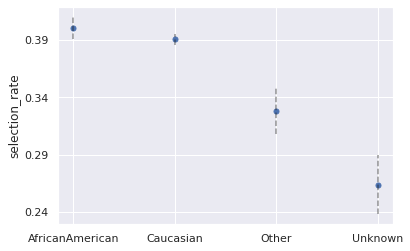

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "selection_rate", "selection_err_bar")

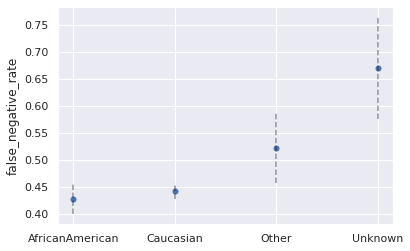

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "false_negative_rate", "fnr_err_bar")

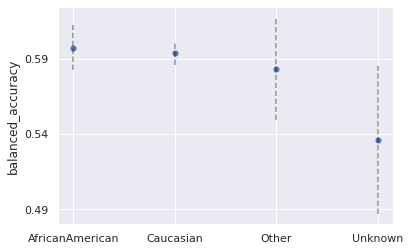

In [ ]:
plot_group_metrics_with_error_bars(metricframe_unmitigated_w_err, "balanced_accuracy", "bal_acc_err_bar")

As we see above, even accounting for the larger uncertainty in estimating the false negative rate for *Unknown*, this group is experiencing substantially larger false negative rate than other groups and thus experiences the harm of allocation.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!ls "/content/drive/My Drive/Colab Notebooks/RSS_organised/"

!jupyter nbconvert '/content/drive/My Drive/Colab Notebooks/RSS_organised/P2FairlearnEthicalAI.ipynb' &> /dev/null

Mounted at /content/drive
